In [1]:
import glam

import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt

In [2]:
import pymc3 as pm

In [3]:
np.random.seed(23) # from random.org

# 3.1. Hierarchical GLAM estimation and out of sample prediction

## Load data

In [4]:
# Load data
sufix = '_Like_NoBin_NUTS_31'
data = pd.read_csv('data/FF2018_data/GlamDataFF2018_Like_NoBin_31.csv')
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,0,0,0,2009,1.10,0.95,0.568396,0.431604
1,0,1,0,3371,2.00,1.70,0.762332,0.237668
2,0,2,1,1700,1.10,2.30,0.446809,0.553191
3,0,3,1,7466,1.25,1.40,0.532352,0.467648
4,0,4,1,1889,2.00,2.30,0.529736,0.470264


In [5]:
data.subject.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

## Split data in training and test sets

In [6]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

#test_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
#train_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1860 trials) and test (1860 trials) sets...


## Hierarchical GLAM estimation

### 1. full GLAM

In [7]:
# Fitting full GLAM
print('Fitting full GLAM hierarchically...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy')):
    glam_full.make_model('hierarchical', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))   
# Save parameter estimates
#np.save(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'), glam_full.estimates)
#pd.DataFrame(glam_full.estimates)

Fitting full GLAM hierarchically...
  Found old parameter estimates in "results/estimates". Skipping estimation...


In [8]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_FF2018_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full.waic = np.load(str('results/waic/glam_FF2018_full'+ sufix +'.npy'))

# Compute WAICs
#np.save(str('results/waic/glam_FF2018_full'+ sufix +'.npy'), glam_full.waic)

Computing WAIC scores for full model...
  Found old DIC scores in "results/waic". Skipping WAIC computation...


In [9]:
glam_full.waic

array([3.27043273e+04, 0.00000000e+00, 6.66645263e+01, 1.00000000e+00])

In [10]:
# Compute LOO


# if not available
#glam_full.loo = pm.loo(trace=glam_full.trace, model=glam_full.model)

# if available
glam_full.loo = np.load(str('results/loo/glam_FF2018_full'+ sufix +'.npy'))

glam_full.loo
#np.save(str('results/loo/glam_FF2018_full'+ sufix +'.npy'), glam_full.loo)

array([3.26533660e+04, 0.00000000e+00, 4.11839095e+01, 1.00000000e+00])

In [11]:
glam_full.loo

array([3.26533660e+04, 0.00000000e+00, 4.11839095e+01, 1.00000000e+00])

In [12]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1860 trials) with new data (1860 trials)...
  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,3360.0,0.0,0.0,2.0,0.762332,1.7,0.237668
1,0.0,1.0,1598.0,0.0,0.0,2.0,0.762332,1.7,0.237668
2,0.0,2.0,2172.0,0.0,0.0,2.0,0.762332,1.7,0.237668
3,0.0,3.0,2779.0,0.0,0.0,2.0,0.762332,1.7,0.237668
4,0.0,4.0,1360.0,0.0,0.0,2.0,0.762332,1.7,0.237668


### 1. no-bias GLAM

In [13]:
# Fitting no-bias GLAM
print('Fitting no-bias GLAM hierarchically...')

glam_nobias = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy')):
    glam_nobias.make_model('hierarchical', gamma_val=1.0, t0_val=0)
    glam_nobias.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_nobias.estimates = np.load(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy'))
 

Fitting no-bias GLAM hierarchically...
  Found old parameter estimates in "results/estimates". Skipping estimation...


In [14]:
   
# Save parameter estimates
#np.save(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy'), glam_nobias.estimates)
pd.DataFrame(glam_nobias.estimates)

ValueError: Must pass 2-d input

In [15]:
# In case it is already fitted
params_part_like = pd.DataFrame.from_dict(glam_nobias.estimates.item(0))
params_part_like

,v_sd,tau_sd,v_mu,s,v,SNR,SNR_sd,gamma,t0,tau_mu,p_error,tau,b,SNR_mu
0,0.000015,0.76,0.000058,0.007513,0.000048,177.66,31.4,1.0,0.0,1.29,0.05,2.77,1.0,144.07
1,0.000015,0.76,0.000058,0.010208,0.000039,127.76,31.4,1.0,0.0,1.29,0.05,2.07,1.0,144.07
2,0.000015,0.76,0.000058,0.009075,0.000057,155.13,31.4,1.0,0.0,1.29,0.05,1.95,1.0,144.07
3,0.000015,0.76,0.000058,0.006931,0.000050,413.19,31.4,1.0,0.0,1.29,0.05,1.80,1.0,144.07
4,0.000015,0.76,0.000058,0.007725,0.000090,91.02,31.4,1.0,0.0,1.29,0.05,3.32,1.0,144.07
5,0.000015,0.76,0.000058,0.007489,0.000032,496.86,31.4,1.0,0.0,1.29,0.05,1.32,1.0,144.07
6,0.000015,0.76,0.000058,0.009102,0.000086,105.38,31.4,1.0,0.0,1.29,0.05,3.40,1.0,144.07
7,0.000015,0.76,0.000058,0.006906,0.000048,129.34,31.4,1.0,0.0,1.29,0.05,1.28,1.0,144.07
8,0.000015,0.76,0.000058,0.008900,0.000062,136.84,31.4,1.0,0.0,1.29,0.05,0.10,1.0,144.07
9,0.000015,0.76,0.000058,0.007791,0.000044,140.92,31.4,1.0,0.0,1.29,0.05,3.19,1.0,144.07


In [16]:
# Compute LOO

glam_nobias.loo = pm.loo(trace=glam_nobias.trace, model=glam_nobias.model)
glam_nobias.loo

#np.save(str('results/loo/glam_FF2018_nobias'+ sufix +'.npy'), glam_nobias.loo)

AttributeError: 'GLAM' object has no attribute 'trace'

In [17]:
# Predictions
print('Predicting test set data using no-bias GLAM...')
glam_nobias.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv')):
    glam_nobias.predict(n_repeats=50)
    glam_nobias.prediction.to_csv(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical no-bias GLAM predictions in "results/predictions". Skipping prediction...')
    glam_nobias.prediction = pd.read_csv(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv'))

glam_nobias.prediction.head()

Predicting test set data using no-bias GLAM...
Replaced attached data (1860 trials) with new data (1860 trials)...
  Found old hierarchical no-bias GLAM predictions in "results/predictions". Skipping prediction...


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,4306.0,0.0,0.0,2.0,0.762332,1.7,0.237668
1,0.0,1.0,1850.0,0.0,0.0,2.0,0.762332,1.7,0.237668
2,0.0,2.0,2673.0,0.0,0.0,2.0,0.762332,1.7,0.237668
3,0.0,3.0,3377.0,0.0,0.0,2.0,0.762332,1.7,0.237668
4,0.0,4.0,3097.0,0.0,0.0,2.0,0.762332,1.7,0.237668


## 2. Plot fit

Close Figure to continue...
hola2
left_minus_mean_others
-1.5    0.000000
-1.4    0.000000
-1.3    0.000000
-1.2    0.000000
-1.1    0.000000
-1.0    0.066667
-0.9    0.166667
-0.8    0.096154
-0.7    0.222222
-0.6    0.043478
-0.5    0.168000
-0.4    0.233611
-0.3    0.175556
-0.2    0.253149
-0.1    0.387010
 0.0    0.461014
 0.1    0.633243
 0.2    0.731736
 0.3    0.791964
 0.4    0.677041
 0.5    0.889881
 0.6    0.777778
 0.7    0.885417
 0.8    0.864286
 0.9    0.857143
 1.0    0.972222
 1.1    0.833333
 1.2    1.000000
 1.3    1.000000
 1.4    1.000000
 1.5    1.000000
Name: left_chosen, dtype: float64
hola2
left_minus_mean_others
-1.5    0.060000
-1.4    0.160000
-1.3    0.010000
-1.2    0.095000
-1.1    0.060000
-1.0    0.079111
-0.9    0.103889
-0.8    0.090769
-0.7    0.199444
-0.6    0.138116
-0.5    0.174613
-0.4    0.185500
-0.3    0.193721
-0.2    0.272720
-0.1    0.364484
 0.0    0.500226
 0.1    0.611013
 0.2    0.727819
 0.3    0.774500
 0.4    0.744719
 0.5    0.841

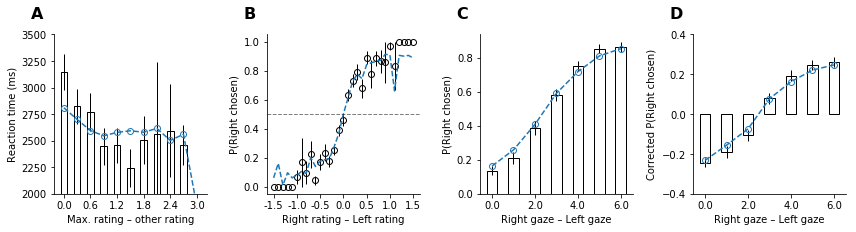

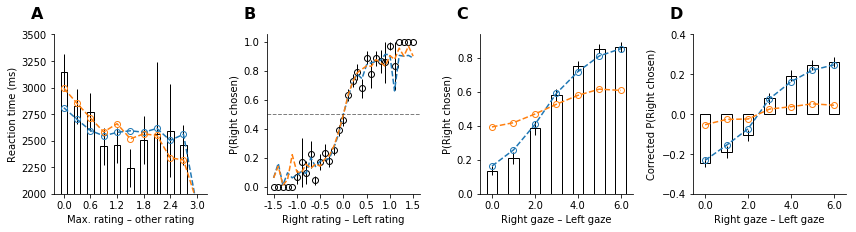

In [18]:
print('Close Figure to continue...')
glam.plot_fit(test_data, [glam_full.prediction]);
glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);

plt.show()

In [19]:
## Test plot fixed

hola2
left_minus_mean_others
-1.5    0.000000
-1.4    0.000000
-1.3    0.000000
-1.2    0.000000
-1.1    0.000000
-1.0    0.066667
-0.9    0.166667
-0.8    0.096154
-0.7    0.222222
-0.6    0.043478
-0.5    0.168000
-0.4    0.233611
-0.3    0.175556
-0.2    0.253149
-0.1    0.387010
 0.0    0.461014
 0.1    0.633243
 0.2    0.731736
 0.3    0.791964
 0.4    0.677041
 0.5    0.889881
 0.6    0.777778
 0.7    0.885417
 0.8    0.864286
 0.9    0.857143
 1.0    0.972222
 1.1    0.833333
 1.2    1.000000
 1.3    1.000000
 1.4    1.000000
 1.5    1.000000
Name: left_chosen, dtype: float64
hola2
left_minus_mean_others
-1.5    0.060000
-1.4    0.160000
-1.3    0.010000
-1.2    0.095000
-1.1    0.060000
-1.0    0.079111
-0.9    0.103889
-0.8    0.090769
-0.7    0.199444
-0.6    0.138116
-0.5    0.174613
-0.4    0.185500
-0.3    0.193721
-0.2    0.272720
-0.1    0.364484
 0.0    0.500226
 0.1    0.611013
 0.2    0.727819
 0.3    0.774500
 0.4    0.744719
 0.5    0.841030
 0.6    0.854222
 0.7   

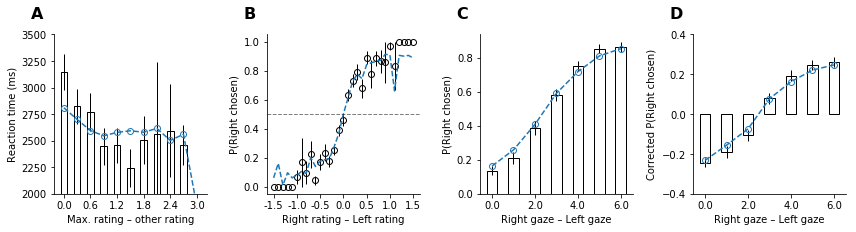

In [20]:
glam.plot_fit(test_data, [glam_full.prediction]);

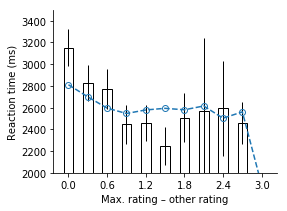

In [21]:
glam.plots.plot_rt_by_difficulty(test_data, glam_full.prediction,
                          xlims =(0, 51), xlabel_skip=2)

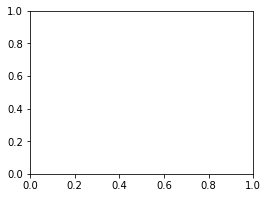

In [22]:
fig, ax = plt.subplots(figsize=(4, 3))
dataframes = [test_data] + [glam_full.prediction]


In [23]:
df = glam.plots.add_left_minus_mean_others(test_data)


In [24]:
df
value_cols = ([col for col in df.columns
                   if col.startswith('item_value_')])


In [25]:
n_items = len(value_cols)
values = df[value_cols].values
values

left_minus_mean_others = values[:, 0] - np.mean(values[:, 1:], axis=1)

In [29]:
len(values[:, 0])

1860

In [27]:
left_minus_mean_others

array([ 0.3 , -0.15, -0.15, ..., -1.45,  0.05, -1.35])

In [26]:
df.left_minus_mean_others.unique()

array([-0.2,  0.1, -0.4,  0.4,  0.5,  0.3,  0.2,  0. , -0.1, -0.3, -0.5,
       -0.6, -0.8, -1.2, -1. ,  0.7, -1.5,  1.4, -0.7,  0.6, -0.9,  1.2,
       -1.4,  1.1,  1.5,  0.9, -1.3,  0.8,  1. ,  1.3, -1.1])

In [45]:
len(df.left_minus_mean_others.unique())

167

In [25]:
levels =  (np.max(df.left_minus_mean_others) - np.min(df.left_minus_mean_others))/10

In [27]:
np.max(df.left_minus_mean_others)

3.0

In [28]:
np.min(df.left_minus_mean_others)

-3.0

In [26]:
levels

0.6

In [31]:
levels =  (np.max(left_minus_mean_others) - np.min(left_minus_mean_others))/10
levels

lev_label = np.arange(np.min(left_minus_mean_others), np.max(left_minus_mean_others) + levels,levels) 

In [32]:
lev_label

array([-3.0000000e+00, -2.4000000e+00, -1.8000000e+00, -1.2000000e+00,
       -6.0000000e-01,  4.4408921e-16,  6.0000000e-01,  1.2000000e+00,
        1.8000000e+00,  2.4000000e+00,  3.0000000e+00])

In [49]:
len(np.unique(np.around(left_minus_mean_others,decimals= 0)))

7

In [33]:
left_minus_mean_others2= []
for i in range(len(left_minus_mean_others)):
     left_minus_mean_others2.append( lev_label[ int(left_minus_mean_others[i]//levels)] )
    

In [34]:
left_minus_mean_others2

[-3.0,
 3.000000000000001,
 3.000000000000001,
 -2.4,
 2.4000000000000004,
 2.4000000000000004,
 -2.4,
 2.4000000000000004,
 3.000000000000001,
 -3.0,
 -3.0,
 -3.0,
 -3.0,
 -3.0,
 3.000000000000001,
 -3.0,
 3.000000000000001,
 -3.0,
 2.4000000000000004,
 -3.0,
 -3.0,
 -3.0,
 3.000000000000001,
 -3.0,
 -2.4,
 -2.4,
 2.4000000000000004,
 -2.4,
 2.4000000000000004,
 3.000000000000001,
 3.000000000000001,
 -2.4,
 -3.0,
 2.4000000000000004,
 2.4000000000000004,
 -2.4,
 -3.0,
 -3.0,
 -3.0,
 -2.4,
 -3.0,
 3.000000000000001,
 -3.0,
 -2.4,
 -2.4,
 3.000000000000001,
 -3.0,
 -1.7999999999999998,
 -2.4,
 -2.4,
 3.000000000000001,
 2.4000000000000004,
 2.4000000000000004,
 -2.4,
 3.000000000000001,
 3.000000000000001,
 -2.4,
 -3.0,
 -3.0,
 3.000000000000001,
 3.000000000000001,
 3.000000000000001,
 -3.0,
 -3.0,
 -3.0,
 -3.0,
 -3.0,
 2.4000000000000004,
 -3.0,
 3.000000000000001,
 -3.0,
 3.000000000000001,
 3.000000000000001,
 -3.0,
 -3.0,
 -3.0,
 -3.0,
 3.000000000000001,
 -3.0,
 2.400000000000000

In [23]:
values_sorted = np.sort(values, axis=1)
difficulty = values_sorted[:, -1] - np.mean(values_sorted[:, :-1], axis=1)

In [30]:
left_minus_mean_others

array([ 0.3 , -0.15, -0.15, ..., -1.45,  0.05, -1.35])

In [67]:
df['difficulty'] = difficulty

In [68]:
df

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1,difficulty
1,0,1,0,3371,2.00,1.70,0.762332,0.237668,0.30
3,0,3,1,7466,1.25,1.40,0.532352,0.467648,0.15
5,0,5,1,2227,1.70,1.85,0.370529,0.629471,0.15
7,0,7,0,3505,1.55,0.80,0.670739,0.329261,0.75
9,0,9,1,3226,1.10,2.00,0.581579,0.418421,0.90
11,0,11,0,6333,0.95,2.00,0.639856,0.360144,1.05
13,0,13,0,3562,2.00,1.10,0.716526,0.283474,0.90
15,0,15,1,2120,1.25,1.85,0.356049,0.643951,0.60
17,0,17,1,4274,1.25,1.70,0.433806,0.566194,0.45
19,0,19,0,6698,1.10,1.10,0.668006,0.331994,0.00


In [92]:
levels =  (np.max(difficulty) - np.min(difficulty))/10
levels

lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 

In [93]:
lev_label

array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ])

In [94]:
lev_label[0]

0.0

In [95]:
difficulty[1]//levels

0.0

In [96]:
difficulty2= []
for i in range(len(difficulty)):
     difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
    

In [97]:
difficulty2

[0.3,
 0.0,
 0.0,
 0.6,
 0.6,
 0.8999999999999999,
 0.6,
 0.6,
 0.3,
 0.0,
 0.0,
 0.3,
 0.0,
 0.0,
 0.3,
 0.3,
 0.6,
 0.3,
 0.8999999999999999,
 0.3,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8999999999999999,
 0.6,
 0.6,
 0.6,
 0.6,
 0.0,
 0.3,
 0.6,
 0.0,
 0.6,
 0.6,
 0.8999999999999999,
 0.3,
 0.0,
 0.3,
 0.8999999999999999,
 0.3,
 0.0,
 0.3,
 0.6,
 0.6,
 0.3,
 0.0,
 1.5,
 0.8999999999999999,
 0.6,
 0.0,
 0.6,
 0.6,
 0.6,
 0.3,
 0.0,
 0.6,
 0.3,
 0.0,
 0.0,
 0.3,
 0.0,
 0.0,
 0.0,
 0.3,
 0.3,
 0.0,
 0.6,
 0.0,
 0.0,
 0.3,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3,
 0.0,
 0.3,
 0.0,
 0.6,
 0.0,
 0.3,
 0.6,
 0.0,
 0.3,
 0.0,
 0.0,
 0.3,
 0.3,
 0.3,
 0.3,
 0.6,
 0.0,
 0.0,
 0.3,
 0.0,
 0.0,
 0.0,
 0.3,
 0.3,
 0.3,
 0.0,
 0.0,
 0.0,
 0.3,
 0.3,
 0.0,
 0.6,
 0.0,
 0.0,
 0.3,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3,
 0.0,
 0.3,
 0.0,
 0.6,
 0.8999999999999999,
 2.1,
 1.7999999999999998,
 0.8999999999999999,
 0.0,
 1.2,
 0.0,
 1.2,
 0.0,
 3.0,
 2.6999999999999997,
 1.2,
 0.6,
 0.0,
 0.8999999999999999,
 0.3,
 0.6,
 0.6,
 2.6999

In [98]:
df['difficulty2'] = difficulty2

In [72]:
df

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1,difficulty,difficulty2
1,0,1,0,3371,2.00,1.70,0.762332,0.237668,0.30,1.0
3,0,3,1,7466,1.25,1.40,0.532352,0.467648,0.15,0.0
5,0,5,1,2227,1.70,1.85,0.370529,0.629471,0.15,0.0
7,0,7,0,3505,1.55,0.80,0.670739,0.329261,0.75,2.0
9,0,9,1,3226,1.10,2.00,0.581579,0.418421,0.90,2.0
11,0,11,0,6333,0.95,2.00,0.639856,0.360144,1.05,3.0
13,0,13,0,3562,2.00,1.10,0.716526,0.283474,0.90,2.0
15,0,15,1,2120,1.25,1.85,0.356049,0.643951,0.60,2.0
17,0,17,1,4274,1.25,1.70,0.433806,0.566194,0.45,1.0
19,0,19,0,6698,1.10,1.10,0.668006,0.331994,0.00,-0.0


In [65]:
difficulty[1]//levels

0.0

In [55]:
np.max(difficulty)

3.0

In [56]:
np.min(difficulty)

0.0

## Parameters for full hierarchical model

In [ ]:
params_participant = glam_full.estimates.item(0)
params_participant = pd.DataFrame.from_dict(glam_full.estimates.item(0))

In [ ]:
params_participant

In [ ]:
print ("Mean gamma " +  str(params_participant['gamma'].mean()))

In [ ]:
hist = params_participant[['SNR','gamma','tau','v']].hist(figsize = [20,3] , layout=[1,4],bins = 20)

## [END] 

In [ ]:
testa = glam_nobias.prediction

In [ ]:
xlims =(0, 10)

# Compute relevant variables
df = glam.plots.add_difficulty(testa)

# Compute summary statistics
subject_means = df.groupby(['subject', 'difficulty']).rt.mean()
means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]


In [ ]:
means